# Characterizing temporal correlations in the binned killifish data

An important set of hyperparameters to identify for the Dirichlet Tucker Decomposition are the ranks, or dimensionality, of each latent factor.
Since this model is unsupervised, we can infer the optimal modal ranks by selecting a subset of entries to mask and hold-out from the fitting procedure.
We evaluate the fitted model performance, for the given set of hyperparameters, on these held-out entries.

"Speckled" holdout, in which entries in the data tensor are randomly heldout, is a common strategy for holding-out data for matrix and tensor decompositions (Wold, 1978; [Williams, 2018](https://www.sciencedirect.com/science/article/pii/S0896627318303878?via%3Dihub) and [Williams, 2018 (_blog_)](https://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/).)
However, when the data tensor contains spatial or temporal modes, for example, the neighboring entries of a masked element may still be highly correlated
and therefore result in unrepresentatively high cross-validated performance.
This is suggested in the TCA results, where Williams et al. found that ...
and in Bedbrook, Nath, et al., where they cross-validated the DTD model with 50% of the elements.

Pellegrino et al. (2024) employed a "blocked masking" procedure along their time mode, and additional specified a buffer around each block to discard.
This is justfiied by the mixing times, see Fox et al. 2015.

The killifish data (`killifish-10min-20230726`) consists of behavioral syllable usage counts, for $V$ syllables, at each timepoint.
The data associated with each subject is structured as a tensor $\mathcal{Y} \in \mathbb{N}^{D^{(i)}\times T \times V}$,
where $D^{(i)}$ is the number of days recorded fo subject $i$, $T$ is the number of time points per day, and $V$ is the number of syllables.

Data across subjects are aligned along the time-of-day $T$ and syllable $V$ modes.

The data is a binned at fixed, non-overlapping windows (here, 10 minutes, so $T=144$ timebins per day).
In spite of this binning, the syllable usage data still exhibits

This notebooks expects `.env` file specifying the `KILLIFISH_DATA_DIR` environmental variable pointing to the relevant data directory.

In [64]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

import numpy as onp
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp

import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.pyplot as plt
import seaborn as sns

import dtd
import dtd.data.killifish

load_dotenv();  # load environment variables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
try:
    jax.devices(backend="cuda")
except:
    os.environ["JAX_PLATFORM"] = "cpu"

2024-08-22 23:11:33.971649: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:216] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Temporal similarity of frequency transformed count data

In [57]:
data_dir = os.getenv("KILLIFISH_DATA_DIR")
data = dtd.data.killifish.construct_subject_concatenated_kf(
    data_dir, mask_frac=0, transform_method="frequency",
)

# Split data by subjects so we don't try to correlate across subjects
names, ages = list(zip(*data['mode_0']))
_, subject_indices = onp.unique(names, return_index=True)

Let's take a look at the syllable usages for a single subject.

In [47]:
i_subject = 6
i_start, i_end = subject_indices[i_subject], subject_indices[i_subject+1]
arr = data['tensor'][i_start:i_end]

D, T, V = arr.shape

print(f"{arr.shape=}")

arr.shape=(230, 144, 100)


In [61]:
arr[30]

Array([[0.00891667, 0.        , 0.        , ..., 0.        , 0.00025   ,
        0.        ],
       [0.00308333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04925   , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00033333],
       ...,
       [0.00716667, 0.02408333, 0.095     , ..., 0.        , 0.        ,
        0.        ],
       [0.0215    , 0.04491667, 0.043     , ..., 0.        , 0.        ,
        0.        ],
       [0.00516667, 0.04041667, 0.06066667, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

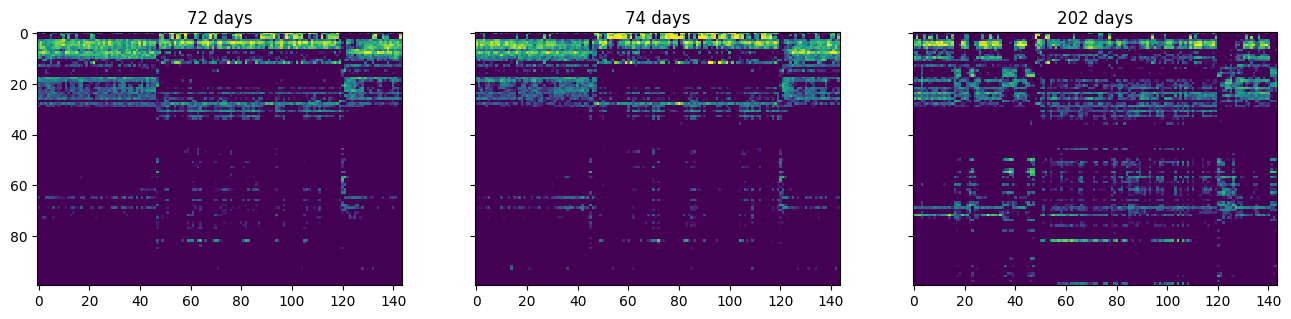

In [65]:
# Select 3 days at random to show
indices = jnp.sort(jr.permutation(jr.key(6), D)[:3])

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,9))

vmax = jnp.percentile(arr, 99.7)
for ax, d in zip(axs, indices):
    ax.imshow(
        (arr[d]+1e-16).T,  # add an epsilon to prevent LogNorm from nan-ing out on 0-counts
        norm=mplc.LogNorm(vmin=1./V, vmax=vmax),
        interpolation='none',
    )
    ax.set_title(f"{ages[i_start+d]} days")

    ax.set_yticks()

axs[0].set_ylabel("syllables")

### Similarity across timebins, `(DT, V)`

In [4]:
def lagged_distance(fn, arr, lag: int):
    """Compute lagged negative cross-entropy.

    Parameters
    ----------
    fn: Callable[[ArrayLike, ArrayLike], ArrayLike]
        Distance function between reference vector and lagged vectors,
        taking in ``vec``, shape (V) and ``lagged_vecs``, shape (2*lag, V).
    arr: ArrayLike, shape (N, V)
        2D array of frequency vectors
    lag: int
        Amount of forward and backward lag to compute over.
        ``lag`` must be less than ``N // 2``.

    Returns
    -------
    Array, shape (N-2*lags,)

    """

    lagged_vecs = onp.lib.stride_tricks.sliding_window_view(
        arr, 2*lag+1, axis=0
    ).transpose(0,2,1)  # shape (N-2*lag, 2*lag+1, V)

    def neg_cross_entropy(vec, lags):
        return -jnp.mean(vec * jnp.log(lags), axis=axis)
    
    return jax.vmap(fn)(arr[lag:-lag], lagged_vecs)


In [5]:
i_start, i_end = subject_indices[0], subject_indices[1]
print(f"{data['tensor'][i_start:i_end].shape=}")
arr = data['tensor'][i_start:i_end]

D, T, V = arr.shape
arr = arr.reshape(-1, V)  # flatten, shape (DT, V)

arr = arr + 1e-16  # add noise for log computations

print(f"{arr.shape=}")

data['tensor'][i_start:i_end].shape=(198, 144, 100)
arr.shape=(28512, 100)


In [6]:
methods = {
    "l2 dist": lambda ref, lags: jnp.linalg.norm(ref-lags, axis=-1)/ref.shape[-1],
    "l2 dist on logits": lambda ref, lags: jnp.linalg.norm(jnp.log(ref)-jnp.log(lags), axis=-1)/ref.shape[-1],
    "neg cross-entropy": lambda ref, lags: -jnp.sum(ref * jnp.log(lags), axis=-1)
}

lag = 30  # units: timebins
lagged_results = {fn_name: lagged_distance(fn, arr, lag) for fn_name, fn in methods.items()}


Text(0.5, 0, 'lag [timebins]')

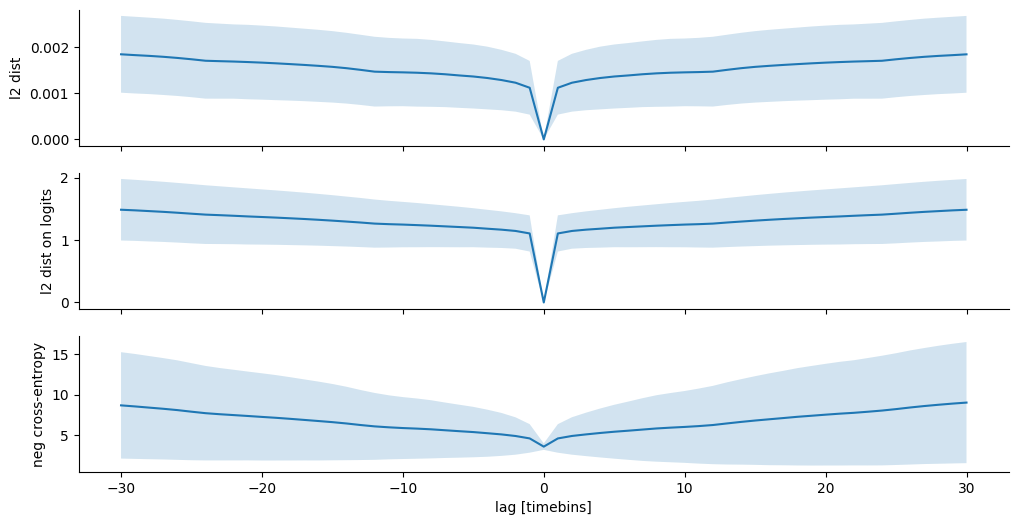

In [7]:
n_methods = len(lagged_results)

fig, axs = plt.subplots(nrows=n_methods, ncols=1, sharex=True, figsize=(12, 2*n_methods))

x = jnp.arange(-lag, lag+1)
for i, (name, out) in enumerate(lagged_results.items()):
    mean = onp.mean(out, axis=0)
    std = onp.std(out, axis=0)

    ax = axs[i]
    ax.plot(x, mean)
    ax.fill_between(x, mean-std, mean+std, alpha=0.2)

    ax.set_ylabel(name)

    ax.spines[["top", "right"]].set_visible(False)

axs[-1].set_xlabel("lag [timebins]")

### Similarity across timebins and days

In [37]:
i_start, i_end = subject_indices[0], subject_indices[1]
arr = data['tensor'][i_start:i_end]

D, T, V = arr.shape
arr = arr + 1e-16  # add noise for log computations

print(f"{arr.shape=}")

lag_days = 7
lag_bins = 6
lagged_mats = onp.lib.stride_tricks.sliding_window_view(
    arr, (2*lag_days+1, 2*lag_bins+1), axis=(0,1)
)  # shape (D-2*lag_days, T-2*lag_bins, V, 2*lag_days+1, 2*lag_bins+1)

print(f"{lag_days=}, {lag_bins=}")
print(f"{lagged_mats.shape=}")

arr.shape=(198, 144, 100)
lag_days=7, lag_bins=6
lagged_mats.shape=(184, 132, 100, 15, 13)


In [38]:
flat_lagged_mats = lagged_mats.reshape(-1, V, 2*lag_days+1, 2*lag_bins+1)

ref_mats = arr[lag_days:-lag_days, lag_bins:-lag_bins].reshape(-1, V)
print(flat_lagged_mats.shape, ref_mats.shape)

(24288, 100, 15, 13) (24288, 100)


In [39]:
out = jnp.sum(ref_mats[:,:,None,None] * jnp.log(flat_lagged_mats), axis=1)
print(f"{out.shape=}")

mean = out.mean(axis=0)
std = jnp.std(out, axis=0)

out.shape=(24288, 15, 13)


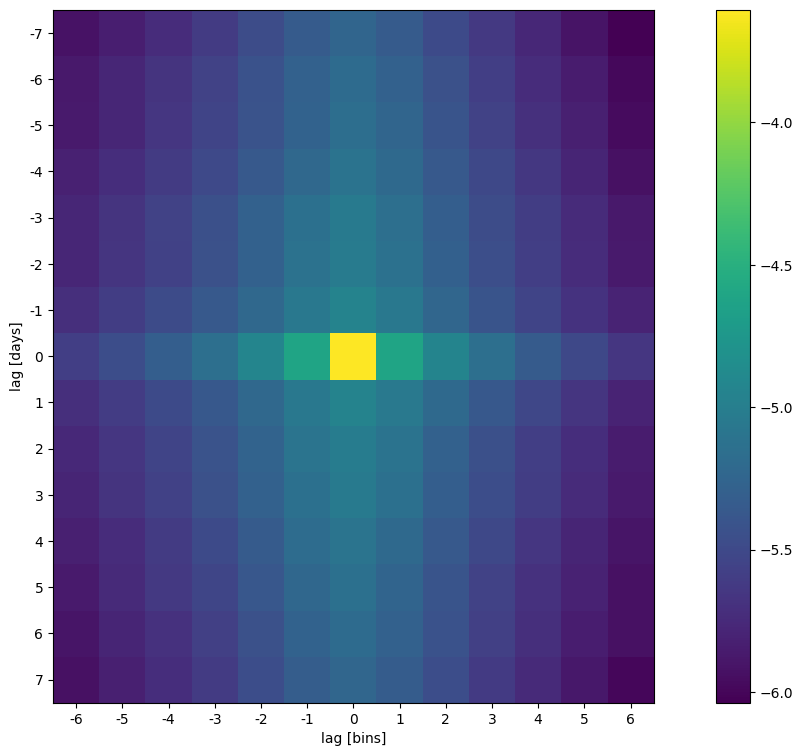

In [40]:
plt.figure(figsize=(16,9))
ax = plt.gca()
im = ax.imshow(mean)

xticklabels = jnp.arange(-lag_bins, lag_bins+1)
yticklabels = jnp.arange(-lag_days, lag_days+1)

ax.set_xticks(jnp.arange(mean.shape[1]))
ax.set_xticklabels(xticklabels)
ax.set_xlabel("lag [bins]")

ax.set_yticks(jnp.arange(mean.shape[0]))
ax.set_yticklabels(yticklabels)
ax.set_ylabel("lag [days]")

plt.colorbar(im)


If we squint, we can pickout that on average, similarity drops off after 4 time bins and 6 days.
However, it's difficult to objectively (or even qualitatively) say because the negative cross entropy term is not standardized.
It technically has a range of $(-\infty, 0]$.

We can attempt to standardize it by setting the vector cross-entropy with itself as the maximum, and the cross-entropy with the average usage during that window as the lower bound.

In [41]:
out.shape, lb.shape, ub.shape, ref_mats.shape

((24288, 15, 13), (18360,), (18360,), (24288, 100))

In [42]:
mean_usage_per_window = flat_lagged_mats.mean(axis=(-1,-2))  # shape (DT, V)

lb = jnp.sum(ref_mats * jnp.log(mean_usage_per_window), axis=1)
ub = jnp.max(out, axis=(1,2))  # (DT,)

standardized_out = (out-lb[:,None,None]) / (ub[:,None,None]-lb[:,None,None])


In [43]:
print(lb)
print(ub)

[-3.366816  -3.186348  -3.3328114 ... -3.2885635 -3.4395509 -3.592064 ]
[-3.2569952 -2.9747007 -3.2293906 ... -2.7824452 -3.1669095 -3.4386446]


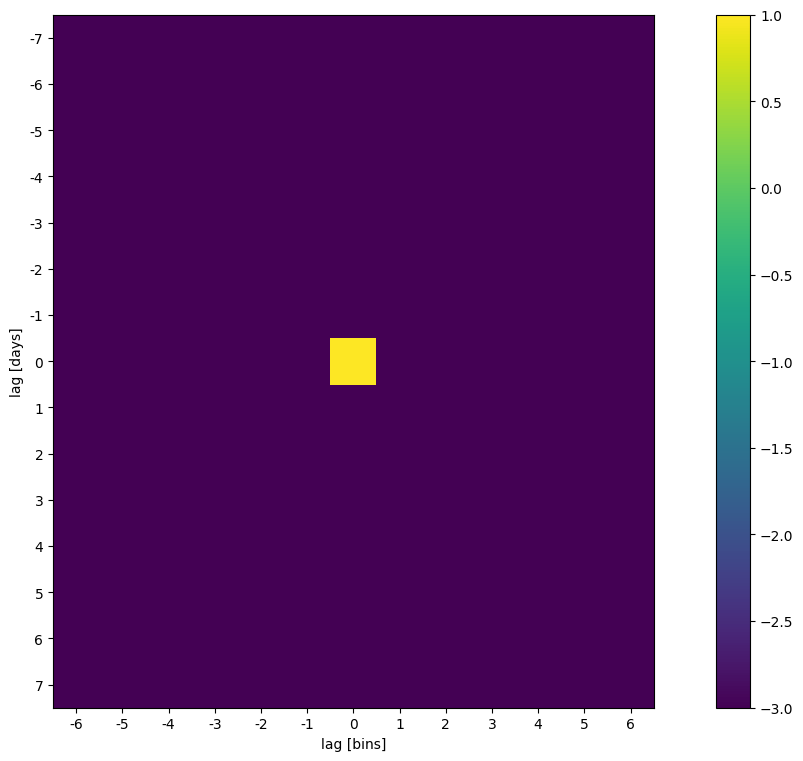

In [44]:
plt.figure(figsize=(16,9))
ax = plt.gca()
im = ax.imshow(standardized_out.mean(axis=0), vmin=-3, vmax=1)

xticklabels = jnp.arange(-lag_bins, lag_bins+1)
yticklabels = jnp.arange(-lag_days, lag_days+1)

ax.set_xticks(jnp.arange(len(xticklabels)))
ax.set_xticklabels(xticklabels)
ax.set_xlabel("lag [bins]")

ax.set_yticks(jnp.arange(len(yticklabels)))
ax.set_yticklabels(yticklabels)
ax.set_ylabel("lag [days]")

plt.colorbar(im)


### Similarity across days, flattening tensor into `(D, TV)`

In [14]:
arr = data['tensor'][i_start:i_end].reshape(-1, 144*100)  # flatten, shape (D, TV)
arr += 1e-16

lag_days = 75
print(f'{lag_days=}')

lagged_views = onp.lib.stride_tricks.sliding_window_view(arr, 2*lag_days+1, axis=0)
print(f"{lagged_views.shape}")  # shape (D-2*lag_bins, V, 2*lag_bins+1)

lag_days=75
(48, 14400, 151)


In [15]:
out = jax.vmap(neg_cross_entropy)(arr[lag_days:-lag_days], lagged_views.transpose(0,2,1))


mean = onp.mean(out, axis=0)
std = onp.std(out, axis=0)

x = jnp.arange(-lag_days, lag_days+1)
plt.plot(x, mean)
plt.fill_between(x, mean-std, mean+std, alpha=0.2)

NameError: name 'neg_cross_entropy' is not defined